# Agent(s) in Haystack

A Haystack `Agent` is a component that can be used in pipelines like any other component. The `Agent` uses the provided "tools" to fulfill the users request.



The `Agent`-class encapsulates lower-level Haystack components like `ChatGenerator` and `ToolInvoker`. It composes these lower-level components into a looping pipeline that runs until a "handoff"-condition is met.

In [1]:
!pip install anthropic-haystack -q

In [2]:
import os
from getpass import getpass
from typing import List

# Standard Haystack imports
from haystack_experimental import Pipeline
from haystack.tools import tool
from haystack.dataclasses import ChatMessage, Document
from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters import OutputAdapter

# Experimental imports needed for our Agent
from haystack_experimental.components.agents import Agent
from haystack_experimental.tools.component_tool import ComponentTool

# We created a set of tools that can interact with GitHub
from github_components.repo_viewer import GithubRepositoryViewer
from github_components.issue_viewer import GithubIssueViewer

/Users/mathislucka/Library/Application Support/hatch/env/virtual/haystack-experimental/0WxCzKa9/test/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from agent_prompts import issue_prompt, repo_viewer_prompt, repo_viewer_schema

In [4]:
def message_handler(documents) -> str:
    result_str = ""
    for document in documents:
        if document.meta["type"] in ["file", "dir", "error"]:
            result_str += document.content + "\n"
        else:
            result_str += f"File Content for {document.meta['path']}\n\n"
            result_str += document.content

    if len(result_str) > 150_000:
        result_str = result_str[:150_000] + "...(large file can't be fully displayed)"

    return result_str

In [5]:
repo_viewer_tool = ComponentTool(
    name="view_repository",
    description=repo_viewer_prompt,
    parameters=repo_viewer_schema,
    component=GithubRepositoryViewer(),
    outputs={
        "message": {"source": "documents", "handler": message_handler},
        "documents": {"source": "documents"},
    },
)

In [6]:
@tool
def create_comment(comment: str) -> str:
    """
    Use this to create a Github comment once you finished your exploration.
    """
    return comment

In [8]:
os.environ["LLM_API_KEY"] = getpass("Anthropic Key: ")

In [9]:
agent = Agent(
    model="anthropic:claude-3-5-sonnet-latest",
    system_prompt=issue_prompt,
    tools=[repo_viewer_tool, create_comment],
    generation_kwargs={"max_tokens": 8000},
    handoff="create_comment",
    state_schema={"documents": {"type": List[Document]}},
)

/Users/mathislucka/Library/Application Support/hatch/env/virtual/haystack-experimental/0WxCzKa9/test/lib/python3.13/site-packages/haystack/components/routers/conditional_router.py:195: UserWarning: Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.
  warn(msg)


In [10]:
issue_template = """
Issue from: {{ url }}
{% for document in documents %}
{% if loop.index == 1 %}
**Title: {{ document.meta.title }}**
{% endif %}
<issue-comment>
{{document.content}}
</issue-comment>
{% endfor %}
    """

issue_builder = ChatPromptBuilder(template=[ChatMessage.from_user(issue_template)])

issue_fetcher = GithubIssueViewer()

In [11]:
pp = Pipeline()

pp.add_component("issue_fetcher", issue_fetcher)
pp.add_component("issue_builder", issue_builder)
pp.add_component("agent", agent)

pp.connect("issue_fetcher.documents", "issue_builder.documents")
pp.connect("issue_builder.prompt", "agent.messages")

🚅 Components
  - issue_fetcher: GithubIssueViewer
  - issue_builder: ChatPromptBuilder
  - agent: Agent
🛤️ Connections
  - issue_fetcher.documents -> issue_builder.documents (List[Document])
  - issue_builder.prompt -> agent.messages (List[ChatMessage])

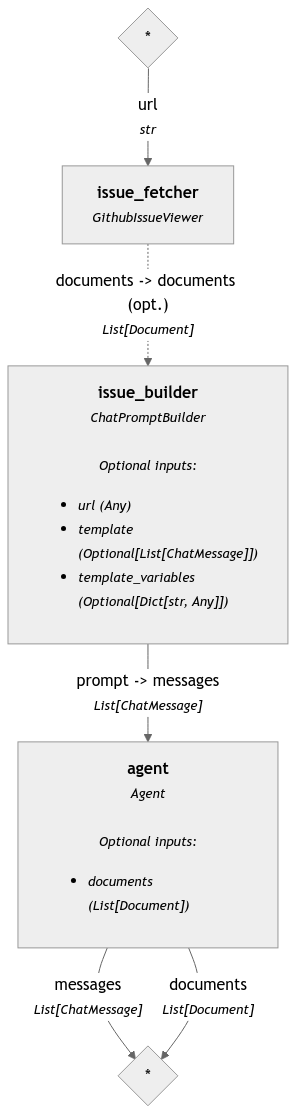

In [12]:
pp.show()

In [13]:
issue_url = "https://github.com/deepset-ai/haystack-core-integrations/issues/1268"

result = pp.run({"url": issue_url})

In [14]:
from IPython.display import display, Markdown
display(Markdown("# Comment from Agent\n\n" + result["agent"]["messages"][-1].tool_call_result.result))

# Comment from Agent

Hi! Thanks for reporting this issue. I've analyzed the code and can confirm the bug.

The problem occurs when passing empty filters (`{}` or `None`) with a custom query. The current implementation always tries to normalize the filters using `normalize_filters()`, which requires specific keys (`operator` and `conditions`) to be present.

I agree with your proposed solution but would suggest a slightly more robust implementation:

```python
if isinstance(custom_query, dict):
    query_placeholders = {"$query_embedding": query_embedding}
    # Only normalize and add filters if they are provided and non-empty
    if filters:
        query_placeholders["$filters"] = normalize_filters(filters)
    body = self._render_custom_query(custom_query, query_placeholders)
```

Key improvements in this version:
1. We skip filter normalization entirely when filters are not provided or empty
2. We only include the `$filters` placeholder in the substitutions when filters are actually present
3. This maintains compatibility with custom queries that might or might not use the `$filters` placeholder

This would allow custom queries to work in three scenarios:
- With valid filters that need normalization
- With empty filters
- Without using filters at all

Would you like me to create a PR with this fix?

_Let's see what files our Agent looked at_

In [15]:
for document in result["agent"]["documents"]:
    if document.meta["type"] in ["file_content"]:
        display(Markdown(f"[{document.meta['url']}]({document.meta['url']})"))

[https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/document_store.py](https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/document_store.py)

[https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/filters.py](https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/filters.py)

# From Agent to Multi-Agent

Let's make this agent a little more powerful.
We will pass the issue comments and the generated proposal to a second agent.
We also fork the original repository so that we can make edits.

The `Agent` will then:
* view relevant files
* perform edits commit by commit
* return a PR title and description once it is ready to go

In [16]:
from github_components.repository_forker import GithubRepoForker
from github_components.file_editor import GithubFileEditor

In [7]:
os.environ["GITHUB_TOKEN"] = getpass("Github Token: ")

In [17]:
repo_forker = GithubRepoForker(create_branch=True, auto_sync=True, wait_for_completion=True)
pp.add_component("repo_forker", repo_forker)

In [18]:
from agent_prompts.pr_system_prompt import system_prompt as pr_prompt
from agent_prompts.file_editor_tool import file_editor_prompt, file_editor_schema

In [19]:
editor_tool = ComponentTool(
    name="file_editor",
    description=file_editor_prompt,
    parameters=file_editor_schema,
    component=GithubFileEditor()
)

@tool
def create_pr(title: str, body: str) -> str:
    """
    Use this to create a Github PR once you are done with your changes.
    """
    return title + "\n\n" + body

In [20]:
pr_agent = Agent(
    model="anthropic:claude-3-5-sonnet-latest",
    system_prompt=pr_prompt,
    tools=[editor_tool, create_pr, repo_viewer_tool],
    generation_kwargs={"max_tokens": 8000},
    handoff="create_pr",
    state_schema={"repo": {"type": str}, "branch": {"type": str}},
)

pp.add_component("pr_agent", pr_agent)
adapter = OutputAdapter(
    template="{{issue_messages + [((agent_messages|last).tool_call_result.result)|user_message]}}",
    custom_filters={"user_message": ChatMessage.from_user},
    output_type=List[ChatMessage], unsafe=True
)
pp.add_component("adapter", adapter)

/Users/mathislucka/Library/Application Support/hatch/env/virtual/haystack-experimental/0WxCzKa9/test/lib/python3.13/site-packages/haystack/components/converters/output_adapter.py:79: UserWarning: Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.
  warn(msg)


In [21]:
pp.connect("repo_forker.issue_branch", "pr_agent.branch")
pp.connect("repo_forker.repo", "pr_agent.repo")
pp.connect("agent.messages", "adapter.agent_messages")
pp.connect("issue_builder.prompt", "adapter.issue_messages")
pp.connect("adapter.output", "pr_agent.messages")

🚅 Components
  - issue_fetcher: GithubIssueViewer
  - issue_builder: ChatPromptBuilder
  - agent: Agent
  - repo_forker: GithubRepoForker
  - pr_agent: Agent
  - adapter: OutputAdapter
🛤️ Connections
  - issue_fetcher.documents -> issue_builder.documents (List[Document])
  - issue_builder.prompt -> agent.messages (List[ChatMessage])
  - issue_builder.prompt -> adapter.issue_messages (List[ChatMessage])
  - agent.messages -> adapter.agent_messages (List[ChatMessage])
  - repo_forker.issue_branch -> pr_agent.branch (str)
  - repo_forker.repo -> pr_agent.repo (str)
  - adapter.output -> pr_agent.messages (List[ChatMessage])

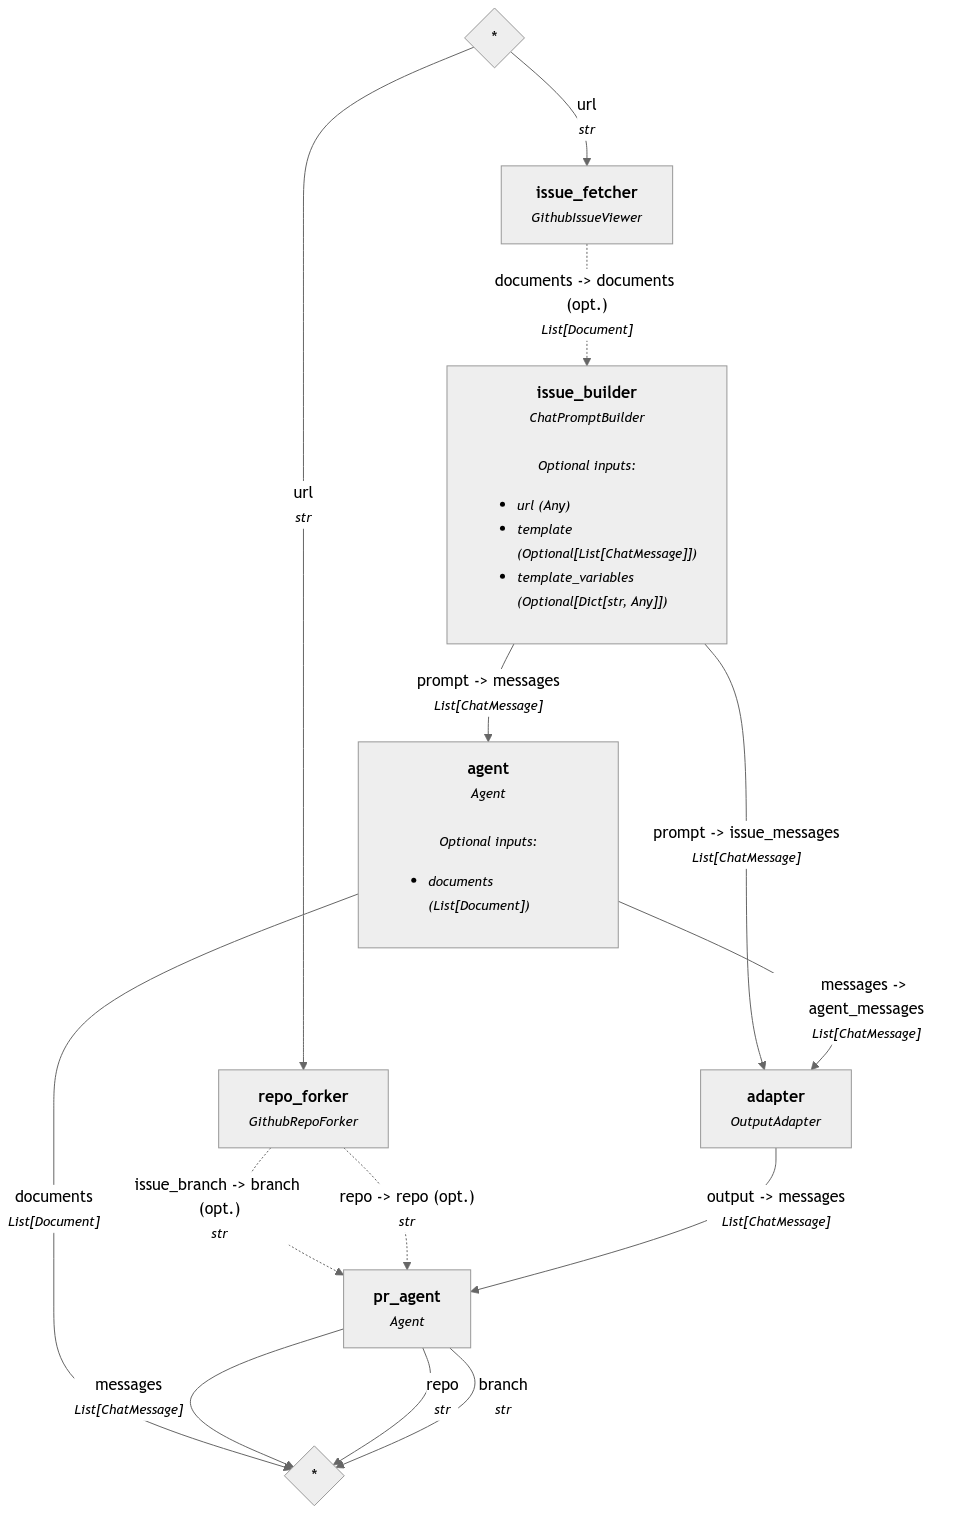

In [22]:
pp.show()